In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import pandas as pd
import seaborn as sns
import os
from PIL import Image
from tensorflow.contrib.tensorboard.plugins import projector

/home/adam/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
tensorboard_dir = './tensorboard_summaries'
if not os.path.isdir(tensorboard_dir):
    os.makedirs(tensorboard_dir)

## Dummy Model

In [ ]:
tensorboard_dm_dir = os.path.join(tensorboard_dir, 'dummy')
if not os.path.isdir(tensorboard_dm_dir):
    os.makedirs(tensorboard_dm_dir)

In [ ]:
experiemnt_name = 'experiment_1'

experiment_dir = os.path.join(tensorboard_dm_dir, experiemnt_name)
if not os.path.isdir(experiment_dir):
    os.makedirs(experiment_dir)
model_path = os.path.join(experiment_dir, 'model.ckpt')


In [ ]:
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('graph_inputs'):
        ph_inputs = tf.placeholder(tf.float32, shape=[None, 3], name='data')
        ph_labels = tf.placeholder(tf.float32, shape=[None, 1], name='labels')
    
    
    with tf.name_scope('prediction'):
        w = tf.get_variable('w', initializer=tf.constant_initializer(0), shape=[3,1])
        predictions = tf.matmul(ph_inputs, w)
    
    
    with tf.name_scope('training'):
        loss = tf.losses.mean_squared_error(ph_labels, predictions)
        train_step = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    global_initializer = tf.global_variables_initializer()

In [ ]:
with graph.as_default():
    saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(experiment_dir, graph)

In [ ]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True

inputs = np.array([[1,2,3]])
labels = np.array([[5]])

with tf.Session(graph=graph, config=config) as session:
    session.run(global_initializer)
    #saver.restore(session, model_path)
    for iteration in range(10):
        _, p, l = session.run([train_step, predictions, loss], feed_dict={ph_inputs: inputs, ph_labels: labels})
        print(l)
    saver.save(session, model_path)

## Flat Img Model

In [ ]:
tensorboard_fim_dir = os.path.join(tensorboard_dir, 'flat_image')
if not os.path.isdir(tensorboard_fim_dir):
    os.makedirs(tensorboard_fim_dir)

In [ ]:
experiemnt_name = 'experiment_1'
sprite_img_file = 'img_meta.png'
metadata_file = 'text_meta.tsv'

experiment_dir = os.path.join(tensorboard_fim_dir, experiemnt_name)
if not os.path.isdir(experiment_dir):
    os.makedirs(experiment_dir)

valid_writer_dir = os.path.join(experiment_dir, 'valid') 
train_writer_dir = os.path.join(experiment_dir, 'train')
sprite_img_path = os.path.join(valid_writer_dir, sprite_img_file)
metadata_file_path = os.path.join(valid_writer_dir, metadata_file)
model_path = os.path.join(valid_writer_dir, 'model.ckpt')

if not os.path.isdir(valid_writer_dir):
    os.makedirs(valid_writer_dir)
if not os.path.isdir(train_writer_dir):
    os.makedirs(train_writer_dir)

In [4]:
data = input_data.read_data_sets('data/fashion/', one_hot=True)
class_id2class_name_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [5]:
def variable_summaries(name, var):
    with tf.name_scope(name):
        mean = tf.reduce_mean(var)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))

        tf.summary.scalar('mean', mean)
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)


def img_summaries(name, var):
    with tf.name_scope(name):
        tf.summary.image(name, var)


def simple_layer(name, input_data, shape, activation='linear'):
    w_name = 'w_' + name
    b_name = 'b_' + name
    if activation == 'relu':
        w = tf.get_variable(w_name, shape=shape, initializer=tf.contrib.layers.variance_scaling_initializer())
    else:
        # w = tf.get_variable('w', initializer=tf.truncated_normal(shape, stddev=0.1))
        w = tf.get_variable(w_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())
    bias = tf.get_variable(b_name, initializer=tf.constant_initializer(0.1), shape=shape[1])
    
    variable_summaries(w_name+'summary', w)
    variable_summaries(b_name+'summary', bias)
    
    output_data = tf.matmul(input_data, w) + bias
    if activation == 'relu':
        output_data = tf.nn.relu(output_data)
    elif activation == 'sigmoid':
        output_data = tf.nn.sigmoid(output_data)
    return output_data

In [ ]:
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('inputs'):
        ph_imgs = tf.placeholder(tf.float32, shape=[None, 784], name='images')
        ph_labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')
    
    with tf.name_scope('simple_layer_1'):
        raw_prediction = simple_layer('layer1', ph_imgs, [784, 10])
            
    with tf.name_scope('prediction'):
        prediction = tf.nn.softmax(raw_prediction)
    
    with tf.name_scope('loss_and_train'):
        cross_entropy_vector = tf.nn.softmax_cross_entropy_with_logits(labels=ph_labels, logits=prediction)
        cross_entropy_loss = tf.reduce_mean(cross_entropy_vector)
        train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy_loss)
        variable_summaries('loss_summary', cross_entropy_vector)
    
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(ph_labels,1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)
        variable_summaries('accuracy_summary', correct_prediction)
        
    with tf.name_scope("embedding_visualization"):
        embedding = tf.Variable(tf.zeros([5000, 10]), name='valid_embedding')
        embedding_assignment = embedding.assign(raw_prediction)
    
    global_initialize = tf.global_variables_initializer()
    merge_summaries = tf.summary.merge_all()

In [ ]:
with graph.as_default():
    saver = tf.train.Saver()

valid_writer = tf.summary.FileWriter(valid_writer_dir, graph)
train_writer = tf.summary.FileWriter(train_writer_dir, graph)

In [6]:
def get_sprite_img(images):
    sprite_img = np.zeros([71*28, 71*28])
    image_id = 0
    for row_id in range(71):
        for col_id in range(71):
            if image_id == 5000:
                break

            row_pos = row_id * 28
            col_pos = col_id * 28

            sprite_img[row_pos:row_pos+28, col_pos:col_pos+28] = images[image_id].reshape(28,28)
            image_id += 1
    
    sprite_img = Image.fromarray(np.uint8(sprite_img * 0xFF))
    return sprite_img
    
def get_label_class_names(label_class_onehots, class_id2class_name_mapping):
    return [class_id2class_name_mapping[int(c_id)] for c_id in np.argmax(label_class_onehots, axis=1).tolist()]


def save_label_class_names(label_class_names, path):
    with open(path, 'w') as fw:
        for name in label_class_names:
            fw.write(name + '\n')

In [ ]:
sprite_img = get_sprite_img(data.validation.images)
sprite_img.save(sprite_img_path)

label_class_names = get_label_class_names(data.validation.labels, class_id2class_name_mapping)
save_label_class_names(label_class_names, metadata_file_path)

In [ ]:
projector_config = projector.ProjectorConfig()
embedding_config = projector_config.embeddings.add()
embedding_config.tensor_name = embedding.name
embedding_config.metadata_path = metadata_file
embedding_config.sprite.image_path = sprite_img_file
embedding_config.sprite.single_image_dim.extend([28, 28])
projector.visualize_embeddings(valid_writer, projector_config)

In [ ]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
        
with tf.Session(graph=graph, config=config) as session:
    session.run(global_initialize)
    for iteration in range(1000):
        batch = data.train.next_batch(100)
        _ = session.run([train_step], feed_dict={ph_imgs: batch[0], ph_labels: batch[1]})
        
        if iteration % 10 == 0:
            summary = session.run([merge_summaries],feed_dict={ph_imgs: batch[0], ph_labels: batch[1]})[0]
            train_writer.add_summary(summary, iteration)
        
        if iteration % 100 == 0:
            _, summary, acc = session.run([embedding_assignment, merge_summaries, accuracy], 
                                          feed_dict={ph_imgs: data.validation.images, 
                                                     ph_labels: data.validation.labels})
            valid_writer.add_summary(summary, iteration)
            saver.save(session, model_path, iteration)
            print('Valid accuracy: {0}'.format(round(acc, 2)))
            
    predictions = session.run([prediction], feed_dict={ph_imgs: data.validation.images})[0]

## Visualization of results

In [37]:
def get_info_df(labels, predictions, images, class_id2class_name_mapping):
    predicted_class_ids_top1 = np.argmax(predictions, axis=1).tolist()
    predicted_class_ids_top3 = np.argsort(predictions, axis=1)[:,-3:].tolist()
    label_class_ids = np.argmax(labels, axis=1).tolist()

    label_class_names = [class_id2class_name_mapping[int(c_id)] for c_id in label_class_ids]
    label_class_scores = predictions[np.arange(5000), label_class_ids].tolist()

    predicted_class_names_top1 = [class_id2class_name_mapping[int(c_id)] for c_id in predicted_class_ids_top1]
    predicted_class_scores_top1 = np.max(predictions, axis=1).tolist()

    predicted_class_names_top3 = []
    selection_class_ids_top3 = []
    
    for label_class_id, predicted_class_ids_triplet in zip(label_class_ids, predicted_class_ids_top3):
        class_id = label_class_id if label_class_id in predicted_class_ids_triplet else predicted_class_ids_triplet[0]
        selection_class_ids_top3.append(class_id)
        predicted_class_names_top3.append(class_id2class_name_mapping[class_id])
    predicted_class_scores_top3 = predictions[np.arange(5000), selection_class_ids_top3].tolist()

    return pd.DataFrame(
        {'label_class_name': label_class_names,
         'label_class_score': label_class_scores,
         'predicted_class_name_top1': predicted_class_names_top1,
         'predicted_class_score_top1': predicted_class_scores_top1,
         'predicted_class_name_top3': predicted_class_names_top3,
         'predicted_class_score_top3': predicted_class_scores_top3,
         'image': list(data.validation.images)
        })

In [72]:
df = get_info_df(data.validation.labels, predictions, data.validation.images, class_id2class_name_mapping)

In [39]:
def get_recall(info_df, class_name):
    true_positives = len(info_df[(info_df.label_class_name==class_name) & (info_df.predicted_class_name_top1==class_name)])
    trues = len(info_df[(info_df.label_class_name==class_name)])
    return round(true_positives / trues * 100, 2)

def get_precision(info_df, class_name):
    true_positives = len(info_df[(info_df.label_class_name==class_name) & (info_df.predicted_class_name_top1==class_name)])
    positives = len(info_df[(info_df.predicted_class_name_top1==class_name)])
    if positives == 0:
        positives = 1
    return round(true_positives / positives * 100, 2)
    
def get_accuracy(info_df):
    return round(float(np.mean((info_df.label_class_name == info_df.predicted_class_name_top1).astype(int))) * 100, 2)

def get_false_positives(info_df, label_class_name, predicted_class_name=None):
    if predicted_class_name is None:
        condition = (info_df['label_class_name']==label_class_name) & (df['predicted_class_name_top1']!=label_class_name)
    else:
        condition = (info_df['label_class_name']==label_class_name) & (df['predicted_class_name_top1']==predicted_class_name)
    return info_df[condition].sort_values(by='predicted_class_score_top1', ascending=False)


In [73]:
get_recall(df, 'Sandal')

99.39

In [74]:
get_precision(df, 'Sandal')

98.59

In [75]:
get_accuracy(df)

91.88

In [76]:
fp = get_false_positives(df, 'Sandal')

In [77]:
def plot_examples(info_df):
    fig = plt.figure(figsize=(20,25))

    examples_count = min(30, len(info_df))
    cols = 5
    rows = np.ceil(examples_count / cols)
    for img_id in range(examples_count):
        ax = plt.subplot(rows, cols, img_id+1)

        img = info_df.image.iloc[img_id].reshape((28,28))
        prediction_name = info_df.predicted_class_name_top1.iloc[img_id]
        prediction_score = info_df.predicted_class_score_top1.iloc[img_id]

        ax.imshow(img , cmap='gray')
        ax.set_title("{0}: {1}".format(prediction_name, round(prediction_score, 2)))
        ax.axes.set_axis_off()

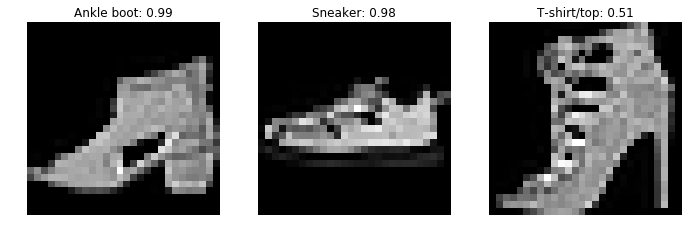

In [78]:
plot_examples(fp[:5])

In [79]:
def plot_coocurance_matrix(info_df, use_log=False, use_top3=False):
    if use_top3:
        coocurance_cols = ['label_class_name', 'predicted_class_name_top3']
    else:
        coocurance_cols = ['label_class_name', 'predicted_class_name_top1']
    coocurance_df = pd.pivot_table(info_df[coocurance_cols], index=coocurance_cols[0], 
                                   columns=coocurance_cols[1], aggfunc=len, fill_value=0)
    if use_log:
        coocurance_df = np.log(coocurance_df)
        coocurance_df = coocurance_df.replace([-np.inf], 0)

    coocurance_df = coocurance_df.div(coocurance_df.sum(axis=1), axis=0) * 100
    coocurance_df = coocurance_df.round(2)
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    sns.heatmap(coocurance_df, ax=ax, annot=True,  linewidths=.5, 
                cbar_kws={"orientation": "horizontal"}, cmap="YlGnBu")
    
    

In [81]:
plot_coocurance_matrix(df, use_log=True)

/home/adam/.pyenv/versions/3.6.3/envs/3.6.3.gpu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [82]:
def get_rec_prec(info_df, class_id2class_name_mapping):
    return pd.DataFrame(
        {
            "class_name": [class_name for class_name in class_id2class_name_mapping.values()],
            "recall": [get_recall(info_df, class_name) for class_name in class_id2class_name_mapping.values()],
            "precision": [get_precision(info_df, class_name) for class_name in class_id2class_name_mapping.values()]
        })

In [83]:
get_rec_prec(df, class_id2class_name_mapping)

class_name  precision  recall
0  T-shirt/top      81.60   91.25
1      Trouser      98.92   98.38
2     Pullover      87.00   86.31
3        Dress      88.58   94.41
4         Coat      85.10   85.45
5       Sandal      98.59   99.39
6        Shirt      82.81   69.37
7      Sneaker      98.22   96.88
8          Bag      98.77   97.96
9   Ankle boot      97.26   98.22

## Convolution model

In [62]:
tensorboard_cnn_dir = os.path.join(tensorboard_dir, 'cnn_image')
if not os.path.isdir(tensorboard_cnn_dir):
    os.makedirs(tensorboard_cnn_dir)

In [63]:
experiemnt_name = 'experiment_1'
sprite_img_file = 'img_meta.png'
metadata_file = 'text_meta.tsv'

experiment_dir = os.path.join(tensorboard_cnn_dir, experiemnt_name)
if not os.path.isdir(experiment_dir):
    os.makedirs(experiment_dir)

valid_writer_dir = os.path.join(experiment_dir, 'valid') 
train_writer_dir = os.path.join(experiment_dir, 'train')
sprite_img_path = os.path.join(valid_writer_dir, sprite_img_file)
metadata_file_path = os.path.join(valid_writer_dir, metadata_file)
model_path = os.path.join(valid_writer_dir, 'model.ckpt')

if not os.path.isdir(valid_writer_dir):
    os.makedirs(valid_writer_dir)
if not os.path.isdir(train_writer_dir):
    os.makedirs(train_writer_dir)

In [64]:
data = input_data.read_data_sets('data/fashion/', one_hot=True)
class_id2class_name_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [65]:
def get_sprite_img(images):
    sprite_img = np.zeros([71*28, 71*28])
    image_id = 0
    for row_id in range(71):
        for col_id in range(71):
            if image_id == 5000:
                break

            row_pos = row_id * 28
            col_pos = col_id * 28

            sprite_img[row_pos:row_pos+28, col_pos:col_pos+28] = images[image_id].reshape(28,28)
            image_id += 1
    
    sprite_img = Image.fromarray(np.uint8(sprite_img * 0xFF))
    return sprite_img


def get_label_class_names(label_class_onehots, class_id2class_name_mapping):
    return [class_id2class_name_mapping[int(c_id)] for c_id in np.argmax(label_class_onehots, axis=1).tolist()]


def save_label_class_names(label_class_names, path):
    with open(path, 'w') as fw:
        for name in label_class_names:
            fw.write(name + '\n')

In [66]:
def variable_summaries(name, var):
    with tf.name_scope(name):
        mean = tf.reduce_mean(var)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))

        tf.summary.scalar('mean', mean)
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)


def img_summaries(name, var):
    with tf.name_scope(name):
        tf.summary.image(name, var)


def conv_summary(name, conv_filter):
    padding = tf.zeros([5, 5, 1, 1])                  # [5, 5, 1, 1]
    conv_filter_padded = tf.concat([conv_filter, padding], 3)  # [5, 5, 1, 25]
    conv_images = tf.split(conv_filter_padded, 25, 3)        # 25 x [5, 5, 1, 1]
    row0 = tf.concat(conv_images[0:5], 0)   # [25, 5, 1, 1]
    row1 = tf.concat(conv_images[5:10], 0)  # [25, 5, 1, 1]
    row2 = tf.concat(conv_images[10:15], 0) # [25, 5, 1, 1]
    row3 = tf.concat(conv_images[15:20], 0) # [25, 5, 1, 1]
    row4 = tf.concat(conv_images[20:25], 0) # [25, 5, 1, 1]
    conv_image = tf.concat([row0, row1, row2, row3, row4], 1) # [25, 25, 1, 1]
    conv_image = tf.reshape(conv_image, [1, 25, 25, 1])
    img_summaries(name, conv_image)        


def simple_layer(name, input_data, shape, activation='linear'):
    w_name = 'w_' + name
    b_name = 'b_' + name
    if activation == 'relu':
        w = tf.get_variable(w_name, shape=shape, initializer=tf.contrib.layers.variance_scaling_initializer())
    else:
        # w = tf.get_variable('w', initializer=tf.truncated_normal(shape, stddev=0.1))
        w = tf.get_variable(w_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())
    bias = tf.get_variable(b_name, initializer=tf.constant_initializer(0.1), shape=shape[1])
    
    variable_summaries(w_name+'summary', w)
    variable_summaries(b_name+'summary', bias)
    
    output_data = tf.matmul(input_data, w) + bias
    if activation == 'relu':
        output_data = tf.nn.relu(output_data)
    elif activation == 'sigmoid':
        output_data = tf.nn.sigmoid(output_data)
    return output_data

In [67]:
sprite_img = get_sprite_img(data.validation.images)
sprite_img.save(sprite_img_path)

label_class_names = get_label_class_names(data.validation.labels, class_id2class_name_mapping)
save_label_class_names(label_class_names, metadata_file_path)

In [68]:
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('inputs'):
        ph_imgs = tf.placeholder(tf.float32, shape=[None, 784], name='images')
        ph_labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')
        keep_prob = tf.placeholder(tf.float32, name='keep_dropout_prob')
        is_training = tf.placeholder(tf.bool, name='is_training')

    
    with tf.name_scope('conv_layer_1'):
        imgs = tf.reshape(ph_imgs, [-1, 28, 28, 1])
        w_conv_1 = tf.get_variable('w_conv_1', [5, 5, 1, 24], 
                                   initializer=tf.contrib.layers.variance_scaling_initializer())
        b_conv_1 = tf.Variable(tf.constant(0.1, shape=[24]))
        conv_summary('w_conv_1_summary', w_conv_1)

        
        conv_layer_1 = tf.nn.conv2d(imgs, w_conv_1, strides=[1, 1, 1, 1], padding='SAME')
        #conv_layer_1 = tf.contrib.layers.batch_norm(conv_layer_1, is_training=is_training, scope='bn1')
        conv_layer_1 = conv_layer_1 + b_conv_1
        conv_layer_1 = tf.nn.relu(conv_layer_1)
        conv_layer_1 = tf.nn.max_pool(conv_layer_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')   

    with tf.name_scope('conv_layer_2'):
        w_conv_2 = tf.get_variable('w_conv_2', [5, 5, 24, 64], initializer=tf.contrib.layers.variance_scaling_initializer())
        b_conv_2 = tf.Variable(tf.constant(0.1, shape=[64]))
  
        conv_layer_2 = tf.nn.conv2d(conv_layer_1, w_conv_2, strides=[1, 1, 1, 1], padding='SAME')
        #conv_layer_2 = tf.contrib.layers.batch_norm(conv_layer_2, is_training=is_training, scope='bn2')
        conv_layer_2 = conv_layer_2 + b_conv_2
        
        conv_layer_2 = tf.nn.relu(conv_layer_2)
        conv_layer_2 = tf.nn.max_pool(conv_layer_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    with tf.name_scope('feed_forward_layer_1'):
        ff_layer_1 = tf.reshape(conv_layer_2, [-1, 7*7*64])
        ff_layer_1 = simple_layer('ff_1', ff_layer_1, shape=[7*7*64, 1024], activation='relu')
        ff_layer_1 = tf.nn.dropout(ff_layer_1, keep_prob)


    with tf.name_scope('feed_forward_layer_2'):
        raw_prediction = simple_layer('ff_2', ff_layer_1, shape=[1024, 10], activation='linear')
        raw_prediction = tf.nn.dropout(raw_prediction, keep_prob)
    
    with tf.name_scope('prediction'):
        prediction = tf.nn.softmax(raw_prediction)
    
    with tf.name_scope("embedding_visualization"):
        embedding = tf.Variable(tf.zeros([5000, 10]), name='valid_embedding')
        embedding_assignment = embedding.assign(raw_prediction)

    with tf.name_scope('loss_and_train'):
        cross_entropy_vector = tf.nn.softmax_cross_entropy_with_logits(labels=ph_labels, logits=raw_prediction)
        cross_entropy_loss = tf.reduce_mean(cross_entropy_vector)
        
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):
            train_step  = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy_loss)
        variable_summaries('loss_summary', cross_entropy_vector)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(ph_labels,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        variable_summaries('accuracy_summary', accuracy)
    
    global_initialize = tf.global_variables_initializer()
    merge_summaries = tf.summary.merge_all()



In [69]:
with graph.as_default():
    saver = tf.train.Saver()
valid_writer = tf.summary.FileWriter(valid_writer_dir, graph)
train_writer = tf.summary.FileWriter(train_writer_dir, graph)

In [70]:
projector_config = projector.ProjectorConfig()
embedding_config = projector_config.embeddings.add()
embedding_config.tensor_name = embedding.name
embedding_config.metadata_path = metadata_file
embedding_config.sprite.image_path = sprite_img_file
embedding_config.sprite.single_image_dim.extend([28, 28])
projector.visualize_embeddings(valid_writer, projector_config)

In [71]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
        
with tf.Session(graph=graph, config=config) as session:
    session.run(global_initialize)
    for iteration in range(10000):
        batch = data.train.next_batch(100)
        _ = session.run([train_step], feed_dict={ph_imgs: batch[0], 
                                                 ph_labels: batch[1], 
                                                 keep_prob: 0.5, 
                                                 is_training: True})
        
        if iteration % 10 == 0:
            summary = session.run([merge_summaries],
                                  feed_dict={ph_imgs: batch[0], 
                                             ph_labels: batch[1], 
                                             keep_prob: 1., 
                                             is_training: False})[0]
            train_writer.add_summary(summary, iteration)
        if iteration % 100 == 0:
            _, summary, acc = session.run([embedding_assignment, merge_summaries, accuracy], 
                                          feed_dict={ph_imgs: data.validation.images, 
                                                     ph_labels: data.validation.labels,
                                                     keep_prob: 1., is_training: False})
            valid_writer.add_summary(summary, iteration)
            saver.save(session, model_path, iteration)
            print('Valid accuracy: {0}'.format(round(acc, 2)))
    predictions = session.run([prediction], feed_dict={ph_imgs: data.validation.images, keep_prob: 1., is_training: False})[0]


Valid accuracy: 0.14000000059604645
Valid accuracy: 0.7799999713897705
Valid accuracy: 0.8299999833106995
Valid accuracy: 0.8600000143051147
Valid accuracy: 0.8600000143051147
Valid accuracy: 0.8600000143051147
Valid accuracy: 0.8700000047683716
Valid accuracy: 0.8700000047683716
Valid accuracy: 0.8799999952316284
Valid accuracy: 0.8799999952316284
Valid accuracy: 0.8799999952316284
Valid accuracy: 0.8799999952316284
Valid accuracy: 0.8799999952316284
Valid accuracy: 0.8799999952316284
Valid accuracy: 0.8799999952316284
Valid accuracy: 0.8899999856948853
Valid accuracy: 0.8799999952316284
Valid accuracy: 0.8899999856948853
Valid accuracy: 0.8899999856948853
Valid accuracy: 0.8999999761581421
Valid accuracy: 0.8999999761581421
Valid accuracy: 0.8899999856948853
Valid accuracy: 0.8999999761581421
Valid accuracy: 0.8999999761581421
Valid accuracy: 0.8999999761581421
Valid accuracy: 0.8999999761581421
Valid accuracy: 0.8999999761581421
Valid accuracy: 0.8999999761581421
Valid accuracy: 0.8